AUC Score (P(Churn)): 0.7187


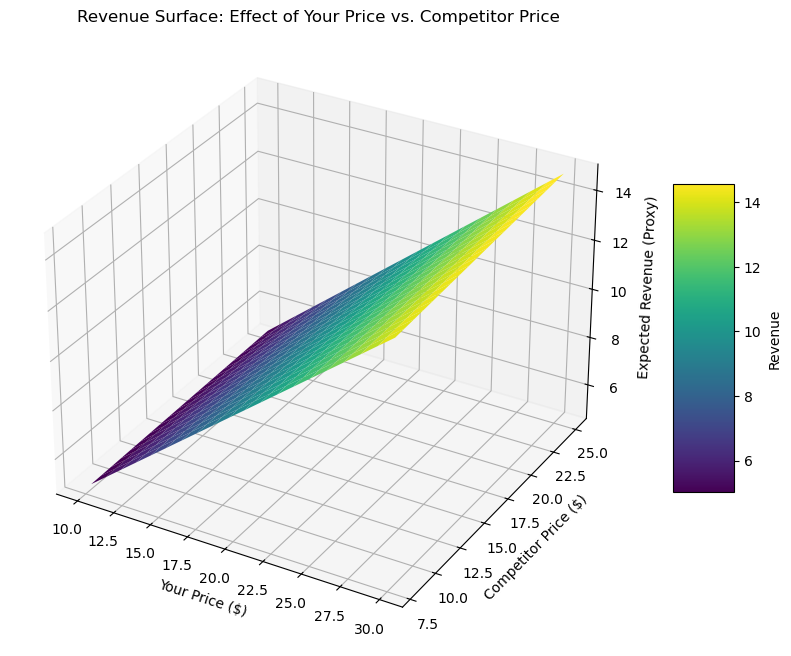

['scaler_rev_opt.pkl']

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import joblib

# --- Setup & Data Loading ---
data = pd.read_csv("C:/Users/Musinguzi/Documents/netflix_pricing_model_results.csv")

# 1. Simulate Required Columns (Price, CompetitorPrice, PreferenceScore)
# Simulating Price (as before, based on ValueSegment)
price_map = {'high': 22, 'medium': 15, 'low': 10, 'very high': 25, 'very low': 8}
data['price'] = data['ValueSegment'].map(price_map).fillna(15)

# Simulate CompetitorPrice (randomly based on existing price)
data['CompetitorPrice'] = data['price'] * np.random.uniform(0.8, 1.2, size=len(data))

# Simulate PreferenceScore (randomly based on Engagementscore)
data['PreferenceScore'] = data['Engagementscore'] * np.random.uniform(0.9, 1.1, size=len(data))

# 2. One-Hot Encoding
categorical_cols = ['Subscriptiontype', 'Paymentmethod', 'ValueSegment', 'Paymentplan']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 3. Define Features (X) and Target (y)
target = 'Churn' 
y = data[target]

available_numeric_features = [
    'Age', 'Numsubscriptionpauses', 'Customerserviceinquiries', 
    'Watchhoursperweek', 'Averagesessionlength', 'Songskiprate', 
    'Weeklysongsplayed', 'Weeklyuniquesongs', 'Numfavoriteartists', 
    'Numplatformfriends', 'Numplaylistscreated', 'Numsharedplaylists', 
    'Notificationsclicked', 'Engagementscore', 'price', 'CompetitorPrice', 'PreferenceScore' # ADDED NEW SIMULATED FEATURES
]

dummy_features = [col for col in data.columns if any(c in col for c in ['Subscriptiontype_', 'Paymentmethod_', 'ValueSegment_'])]

features = available_numeric_features + dummy_features

X = data[features]
y = data[target]

# Ensure all features used in X are present in the columns list (important after feature engineering)
X = X.select_dtypes(include=np.number).drop(columns=[target], errors='ignore')


# --- Model Training (Logistic Regression for P(Churn)) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score (P(Churn)): {auc:.4f}")

# --- STEP 3: DEMAND/REVENUE ANALYSIS ---

# 3a. Define the Demand Function (P(Retention) = 1 - P(Churn))
def predict_retention_proba(input_df, model, scaler, X_cols):
    """Predicts P(Retention) for a given set of features including price."""
    input_scaled = scaler.transform(input_df[X_cols])
    p_churn = model.predict_proba(input_scaled)[:, 1]
    return 1 - p_churn

# --- 3b. Prepare Base Input for Optimization ---
# To plot against Price and CompetitorPrice, we fix all other features (including PreferenceScore)
# to their mean value from the training set.
mean_values = X_train.mean().to_dict()

# --- 3c. 3D Surface Plot Setup ---
# Define the ranges to test for our two variables (Price and CompetitorPrice)
price_range = np.linspace(10, 30, 20) # Test prices between $10 and $30
comp_price_range = np.linspace(8, 25, 20) # Test competitor prices between $8 and $25

# Create the mesh grid for the 3D plot (Z = Revenue, X = Price, Y = CompetitorPrice)
Price_Grid, CompPrice_Grid = np.meshgrid(price_range, comp_price_range)
Revenue_Grid = np.zeros_like(Price_Grid)

# Iterate over every combination of (Price, CompetitorPrice) in the grid
for i in range(Price_Grid.shape[0]):
    for j in range(Price_Grid.shape[1]):
        
        # Set the two variables we are testing
        current_price = Price_Grid[i, j]
        current_comp_price = CompPrice_Grid[i, j]
        
        # Create the input row, holding all other factors constant at their mean
        test_input = base_input_df.copy()
        test_input['price'] = current_price
        test_input['CompetitorPrice'] = current_comp_price
        
        # CRITICAL: Set the simulated PreferenceScore to its mean value
        test_input['PreferenceScore'] = mean_values['PreferenceScore']
        
        # Ensure all other *constant* features are set to their mean from training data
        for col in X_train.columns:
            if col not in ['price', 'CompetitorPrice', 'PreferenceScore']:
                test_input[col] = mean_values.get(col, 0) # Use mean or 0 if feature missing

        # Ensure columns are in the correct order before prediction
        test_input = test_input.reindex(columns=X_train.columns, fill_value=0)

        # Predict Demand (P(Retention))
        demand = predict_retention_proba(test_input, model, scaler, X_train.columns)[0]
        
        # Calculate Revenue
        Revenue_Grid[i, j] = current_price * demand

# --- 3d. Plotting ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(Price_Grid, CompPrice_Grid, Revenue_Grid, 
                       cmap='viridis', 
                       edgecolor='none')

# Labels and Title
ax.set_xlabel('Your Price ($)')
ax.set_ylabel('Competitor Price ($)')
ax.set_zlabel('Expected Revenue (Proxy)')
ax.set_title('Revenue Surface: Effect of Your Price vs. Competitor Price')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, label='Revenue')

plt.show()


# Save final model
joblib.dump(model, 'revenue_optimization_model.pkl')
joblib.dump(scaler, 'scaler_rev_opt.pkl')